# Experiment organization
Goal: Gather results from all topic modeling experiments using many stemming treatments for a particular corpus, then creates some visualizations.
The expected tree structure for the corpus and experiments is as follows:
```
<corpus> # corpus name - 'tiger','rnc' or 'opencorpora'
├── <corpus>_<stemmer> # stemmer or lemmatization treatment name, see topic_modeling/stemming.py for language details
│   ├── <corpus_oracleAnalysis.gz # Only present when stemmer=='oracle', the annotation labels for the words in the corpus, in sequence to match up with state files
│   ├── <corpus>_<stemmer>.mallet # mallet import-dir --output
│   ├── <corpus>_<stemmer>.tsv # output of topic_modeling/corpus_preprocessing.py for this particular treatment
│   ├── <corpus>_<stemmer>_<num_topics>_topics_<num_iters>_iters_<experiment_id> 
│   │   ├── <corpus>_<stemmer>_diagnostics.tsv # mallet train-topics metrics as tsv
│   │   ├── <corpus>_<stemmer>_diagnostics.xml # original mallet train-topics metrics format
│   │   ├── <corpus>_<stemmer>_doc_topics.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_entropy_metrics.tsv # metrics produced by by topic_modeling/mallet_parser slot-entropy
│   │   ├── <corpus>_<stemmer>.model # mallet topic model 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.tsv # mallet train-topics metrics for the version of this model lifted to lemmas 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.xml 
│   │   ├── <corpus>_<stemmer>_postLemmatized.mallet # mallet corpus sequence file lifted to lemmas (we probably only need to create this once, but I didn't think of that earlier, so for now each experiment gets its own)
│   │   ├── <corpus>_<stemmer>_postLemmatized.model # mallet topic model lifted to lemmas
│   │   ├── <corpus>_<stemmer>_postLemmatized_state.gz # mallet topic model state file lifted to 
│   │   ├── <corpus>_<stemmer>_state.gz # mallet topic model state file
│   │   ├── <corpus>_<stemmer>_top_docs.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_topic_keys.txt # mallet train-topics --output-topic-keys
│   │   ├── <corpus>_<stemmer>_topic_lemmas.tsv # Counts and conditional probablilities of lemmas for each topic
│   │   ├── <corpus>_<stemmer>_topic_pos.tsv  # Counts and conditional probablilities of parts-of-speech for each topic
│   │   ├── <corpus>_<stemmer>_topic_slots.tsv  # Counts and conditional probablilities of detailed morphological analyses for each topic
│   │   └── <corpus>_<stemmer>_top_terms.tsv # Raw counts of top 20 terms for each topic
└── voi_<num_topics>_topics # Variation of information between different models for the same number of topics
    └── <corpus>_<stemmer1>_<experiment1_id>_<corpus>_<stemmer2>_<experiment2_id>.tsv # Compares treatment 1 and treatment 2 

```



In [1]:
from pathlib import Path 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="white")

In [2]:
corpus_name = "tiger"
corpus_root = Path("/home/virginia/workspace/topic-modeling-study") / corpus_name
experiment_folders = list(corpus_root.glob(f"{corpus_name}_*/*_topics_*_iters_*"))
voi_folders = list(corpus_root.glob(f"voi_*"))
print("Num experiment folders found:", len(experiment_folders))
print("VOI folders:", voi_folders)

Num experiment folders found: 140
VOI folders: [PosixPath('/home/virginia/workspace/topic-modeling-study/tiger/voi_100_topics'), PosixPath('/home/virginia/workspace/topic-modeling-study/tiger/voi_50_topics')]


In [3]:
def parse_experiment_directory(experiment_path):
    """Parses out all topic level metrics from a topic model's TSV results file, given the model's path. 
    Returns topic level metrics as a dataframe
    """
    dir_name = experiment_path.name
    split_name = dir_name.split("_")
    corpus = split_name[0]
    treatment = split_name[1]
    num_topics = split_name[2]
    experiment_id = split_name[-1]
    original_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_diagnostics.tsv", sep="\t", index_col="id", na_filter=False)

    final_frame = original_mallet_diagnostics

    final_frame.insert(loc = 0, column="corpus", value = corpus)
    final_frame.insert(loc = 1, column="stemmer", value=treatment)
    final_frame.insert(loc = 2, column="num_topics", value=int(num_topics))
    final_frame.insert(loc = 3, column="experiment_id", value = experiment_id)

    lemma_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_postLemmatized_diagnostics.tsv", sep="\t", index_col="id")
    lemma_mallet_diagnostics.rename(columns = {"exclusivity":"lemma_exclusivity"}, inplace=True)
    
    final_frame["lemma_exclusivity"] = lemma_mallet_diagnostics["lemma_exclusivity"]

    entropy_metrics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_entropy_metrics.tsv", sep = "\t", index_col="topic")

    final_frame = pd.merge(final_frame, entropy_metrics, left_index= True, right_index = True)
    final_frame = final_frame.reset_index().rename(columns={"id":"topic_id"})


    return final_frame


In [4]:
# Concat all experiment results together, save off results
full_frame = pd.concat([parse_experiment_directory(f) for f in experiment_folders], ignore_index=True, sort=False)
print("Total entries:", len(full_frame))
full_frame.to_csv(corpus_root / f'{corpus_name}_all_experiments_metrics.tsv', sep='\t', index=False)
full_frame.head()

Total entries: 10500


,topic_id,corpus,stemmer,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
0,0,tiger,snowball,50,8,5495.0,4.9217,6.55,-390.2468,4.1912,3.1576,297.1045,0.0101,0.0500,0.0112,0.0412,0.4404,390.2468,0.7395,9.936789,5.847058,2.268032,2.10,3.25,0.30,symbol welt aktion krieg sinn mensch verantwort demokrat ost evangel deutschland gesellschaft sozial polit kirch volk geschicht kathol pfarr demokrati,Deutschland demokratisch Aktion Demokratie politisch Christ Geschichte Kirche Mensch Krieg sozial katholisch EKD Welt Gesellschaft evangelisch Volk Sinn Osten Pfarrer,soziale Deutschland Evangele sinnen verantworten demokratisch Politik Aktion Verantwortung Ostern Symbolik Demokratie ost politisch Geschichte Kirche Mensch Katholik Krieg Politiker Demokrat katholisch sozial Krieger symbolisch verantwortliche Welt Gesellschaft evangelisch verantwortlich Volk Sinn Kirch Osten Pfarrer Ost Symbol Verantwortlichkeit verantwortend geschichtlich gesellschaftlich Volker,Christ EKD,soziale Evangele sinnen verantworten Politik Verantwortung Ostern Symbolik ost Katholik Politiker Demokrat Krieger symbolisch verantwortliche verantwortlich Kirch Ost Symbol Verantwortlichkeit verantwortend geschichtlich gesellschaftlich Volker,42,2,24
1,1,tiger,snowball,50,8,3142.0,3.8596,5.75,-545.4456,4.1048,3.8789,450.1671,0.0121,0.1103,0.0000,0.0809,0.6390,545.4456,0.6002,9.890514,5.725491,2.166171,1.55,2.90,0.25,mexiko philippin nord spanisch chil mexikan insel meer australi san sud spani colombo land de santiago hauptstadt nordlich stadt sri,Sri spanisch Insel Hauptstadt Colombo Land Meer nördlich Chile San mexikanisch Süden Santiago Mexiko Chamula Norden de Jaffna Stadt Spanien,Sri spanisch Santiagoer philippinisch Insel Mexikaner Hauptstadt hauptstädtisch Colombo Land Nord Meer Australier nördlich Chile San mexikanisch Süden Hauptstädter Spanisch Santiago Mexiko Norden Philippinen de Philippiner Stadt Spanien da Australien Spanier,Chamula Jaffna,hauptstädtisch Hauptstädter Spanisch Santiagoer Nord da philippinisch Mexikaner Australien Philippinen Philippiner Spanier Australier,31,2,13
2,2,tiger,snowball,50,8,7373.0,5.0547,6.50,-313.2359,4.1087,2.8627,322.3903,0.0052,0.1825,0.0308,0.1965,0.4897,313.2359,0.5679,9.891291,5.616719,2.050576,1.45,3.00,0.35,million milliard siem grupp chef ergebnis munch vorstand konz umsatz weltweit unternehm partn beschaftigt firma erlos konzern frankfurt aktionar mark,Firma übernehmen Unternehmen Ergebnis Chef Frankfurt Milliarde Vorstand Gruppe Belegschaft weltweit Siemens Mark Million Konzern Erlös Aktionär Umsatz beschäftigter Partner,Firma Unternehmen Ergebnis Chef Frankfurt Milliarde Vorstand Gruppe Münchener Frankfurter MÜNCHEN München weltweit erlösend Siemens Mark Chefs Million Unternehmer Marke Konzern Erlös Erlösung Aktionär Umsatz beschäftigen beschäftigter erlösen Partner,Belegschaft übernehmen,Unternehmer Marke MÜNCHEN Erlösung München erlösend Münchener beschäftigen Frankfurter Chefs erlösen,29,2,11
3,3,tiger,snowball,50,8,9029.0,4.2369,8.40,-248.3175,4.1628,2.6433,273.8653,0.0090,0.0464,0.0266,0.0372,0.4395,248.3175,0.5694,9.942121,5.710308,2.005119,1.95,3.30,0.35,entwickl mensch wirtschaft national okonomi arbeit marktwirtschaft deutschland gesellschaft modern polit sozial zukunft offent okolog unternehm global arbeitsplatz okonom wirtschaftspolit,Deutschland Wirtschaftspolitik Unternehmen Politik national politisch Entwicklung Wirtschaft Mensch modern sozial Arbeitsplatz ökonomisch Ökonomie global Ge

In [5]:
# Start with examining only 50 topics
topics_50_df = full_frame[full_frame["num_topics"] == 50]
print(len(topics_50_df))
hue_order = ["raw", "oracle", "spacy", "stanza", "snowball", "truncate6", "truncate5"]

3500


# Entropy metrics
Using the annotated corpus as the oracle for lemma, parts of speech and morphological analysis, what's the entropy of topics with respect the original to the grammatical forms of the original wordforms in the documents? 

The treated corpora should have lower lemma entropies, since lemmatiztion forces wordtypes with the same lemma to be together. We would also expect the treated corpora to have higher slot entropy than the raw corpus, because treatments conflate many wordforms with different morphological analyses, but this does not appear to be the case.

- 'raw' has most extreme mean in all cases of entropy metrics - low document entropy & high entropy for grammatical features
- 'raw' (no treatment) has higher lemma and morphological slot entropy than all other treatments. How can the untreated corpus get both higher average lemma entropy and higher average slot entropy? If our expectation is that all forms of a particular lemma concentrate in a given topic (low lemma entropy, high slot entropy), this finding runs counter to that expectation.

<AxesSubplot:xlabel='value', ylabel='entropies'>

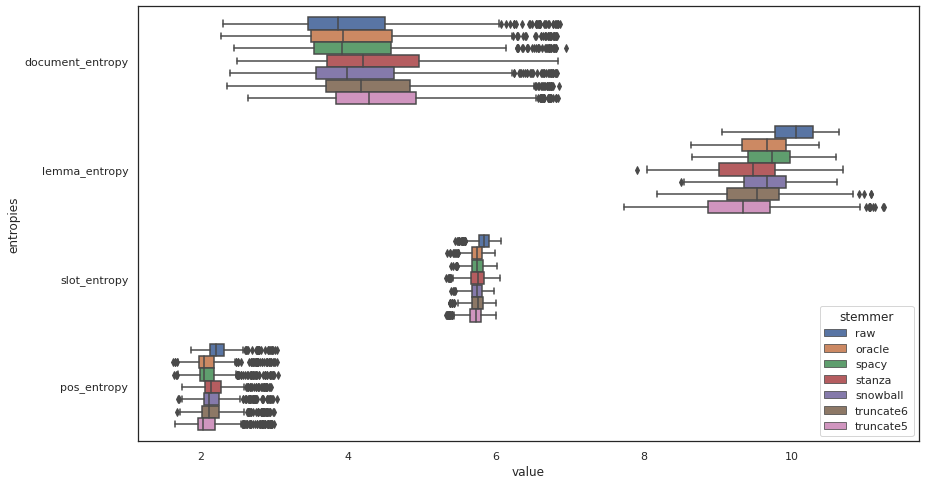

In [6]:
entropy_metrics = ['document_entropy', 'lemma_entropy', 'slot_entropy', 'pos_entropy']
entropy_stats = pd.melt(topics_50_df, "stemmer", var_name="entropies", value_vars=entropy_metrics)

fig, axs = plt.subplots(figsize=(14, 8))
sns.boxplot(x="value", y="entropies", hue="stemmer", data = entropy_stats, hue_order=hue_order)

<AxesSubplot:xlabel='lemma_entropy', ylabel='stemmer'>

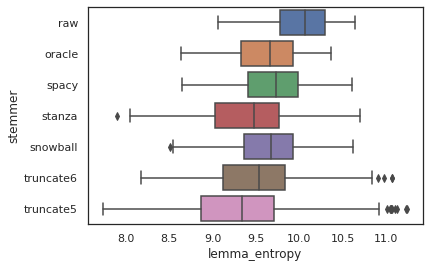

In [7]:
sns.boxplot(x='lemma_entropy', y='stemmer', data=topics_50_df, order=hue_order)

<AxesSubplot:xlabel='slot_entropy', ylabel='stemmer'>

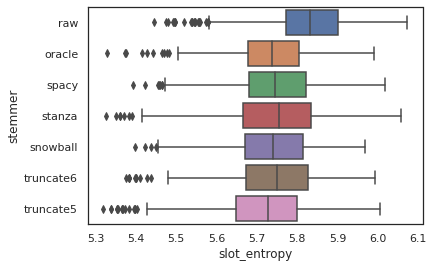

In [8]:
sns.boxplot(x='slot_entropy', y='stemmer', data=topics_50_df, order=hue_order)

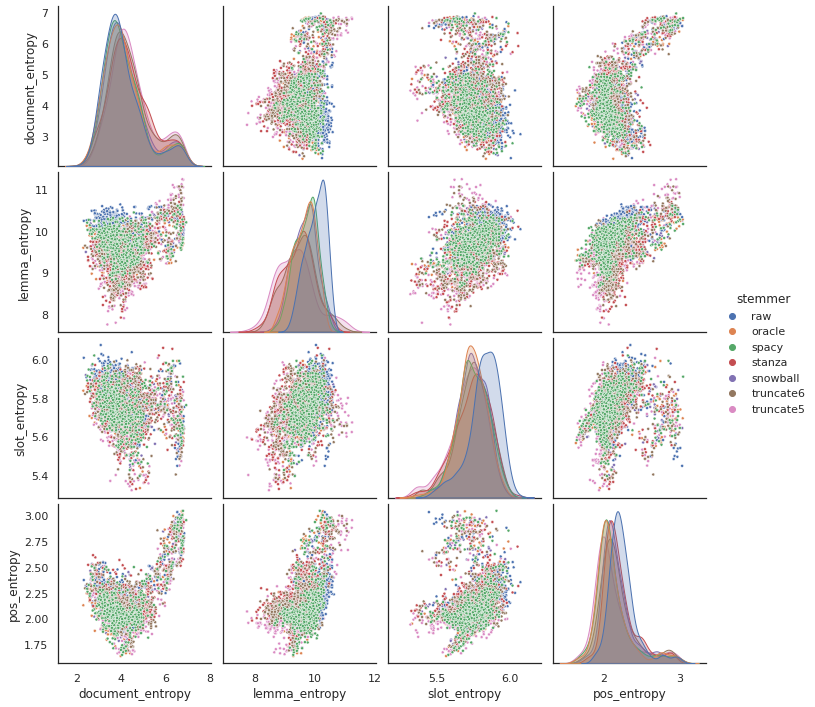

In [9]:
sns.pairplot(topics_50_df, hue="stemmer", vars=entropy_metrics, markers='.', hue_order=hue_order)

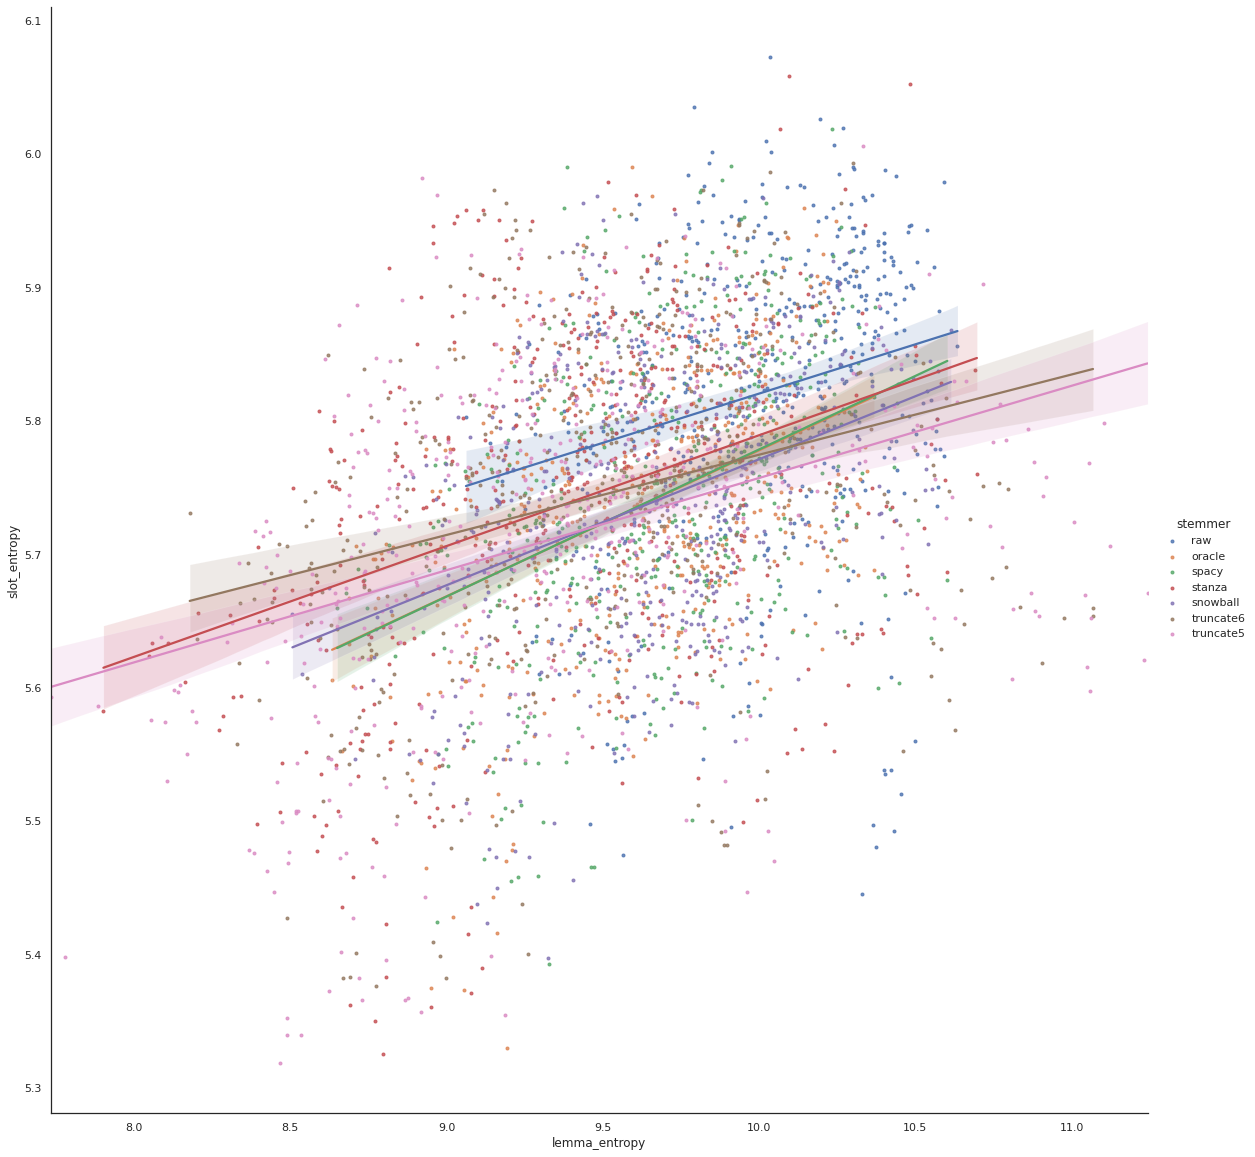

In [10]:
sns.lmplot(data=topics_50_df, x="lemma_entropy", y="slot_entropy", hue="stemmer", markers=".", height=16, hue_order=hue_order)

In [11]:
raw_50_topics_df = topics_50_df[topics_50_df['stemmer'] == 'raw'][['experiment_id', 'topic_id', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]



Text(0.5, 1.0, 'Slot vs. lemma entropy for untreated corpus topic models')

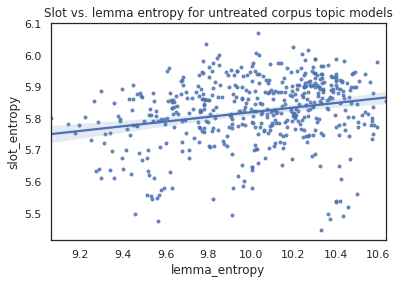

In [12]:
sns.regplot(data=raw_50_topics_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title("Slot vs. lemma entropy for untreated corpus topic models")

In [13]:
raw_50_topics_df.sort_values(['lemma_entropy', 'slot_entropy'], inplace=True)
print("Topics with no treatment, sorted by ascending lemma entropy and slot entropy")
print("Head - low lemma entropy")
display(raw_50_topics_df.head(20))
print("Tail - high lemma entropy")
raw_50_topics_df.tail(20)

Topics with no treatment, sorted by ascending lemma entropy and slot entropy
Head - low lemma entropy


,experiment_id,topic_id,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
4711,9,11,9.062321,5.802552,gingrich präsident usa washington republikanischen clinton dollar powell kongreß veto republikaner perot wto bill republikanern us-präsident mehrheit demokraten präsidenten partei,Demokrat Perot Präsident republikanisch Partei Washington Clinton US-Präsident Republikaner USA Mehrheit weiß Haus Powell Gingrich Kongreß Veto Bill Dollar amerikanisch,Demokrat Perot Präsident republikanisch Partei Washington Wahington Clinton US-Präsident Republikaner USA WTO Mehrheit Powell Gingrich Kongreß Veto Bill Dollar,amerikanisch Haus weiß,19,3
5692,6,42,9.140611,5.783022,dollar republikaner powell veto kongreß gingrich washington us-präsident bill mehrheit wto clintons präsident us-regierung usa perot republikanischen demokraten clinton republikanern,Clinton Kongreß republikanisch Republikaner Haushalt Bill USA Washington Dollar Perot Mehrheit Powell Demokrat US-Präsident Präsident amerikanisch Haus Veto US-Regierung Gingrich,Clinton Wahington Kongreß republikanisch Republikaner Bill USA Washington Dollar Perot Mehrheit Powell Demokrat US-Präsident Präsident Veto WTO US-Regierung Gingrich,amerikanisch Haushalt Haus,19,3
5119,1,19,9.176875,5.754486,gingrich verhandlungen powell präsidenten kongreß bill veto präsident demokraten wto republikanischen us-präsident republikanern dollar perot usa clinton republikaner dienstag washington,Bill WTO Haushalt Republikaner Dienstag Powell Clinton USA Perot Washington Veto US-Präsident Dollar weiß Präsident Haus Demokrat Kongreß Gingrich republikanisch,Bill WTO Republikaner Verhandlung Dienstag Powell Clinton USA Perot Wahington Washington Veto US-Präsident Dollar Präsident Demokrat Kongreß Gingrich republikanisch,Haus weiß Haushalt,19,3
5794,0,44,9.191703,5.780090,perot clinton usa powell veto verhandlungen amerikaner us-präsident republikanischen dollar washington präsidenten republikaner gingrich republikanern demokraten wto bill kongreß präsident,weiß Powell WTO US-Präsident Haus Demokrat Verhandlung Bill Washington USA Präsident Clinton Republikaner Veto republikanisch amerikanisch Perot Kongreß Dollar Gingrich,Powell WTO US-Präsident Amerikaner Demokrat Verhandlung Bill Wahington Washington USA Präsident Clinton Republikaner Veto republikanisch Perot Dollar Kongreß Gingrich,weiß amerikanisch Haus,19,3
4650,8,0,9.223459,5.804593,republikaner gingrich dollar washington regierung powell anc clinton veto kongreß dienstag präsident us-präsident mehrheit weißen republikanern demokraten bill usa präsidenten,Washington Demokrat Regierung Dienstag Republikaner Mehrheit Bill ANC USA Präsident Gingrich republikanisch Haus amerikanisch Clinton weiß Dollar US-Präsident Kongreß Powell,Washington Demokrat Regierung weiße Dienstag Veto Republikaner Mehrheit Bill ANC USA Präsident Gingrich Clinton weiß Dollar US-Präsident Kongreß Powell Wahington,republikanisch Haus amerikanisch,20,3
4984,2,34,9.251487,5.733525,powell mehrheit clinton bill republikanern republikanischen präsidenten usa demokraten dollar republikaner mittwoch gingrich kongreß us-präsident washington dienstag perot veto präsident,Perot USA republikanisch amerikanisch Gingrich Bill Demokrat Kongreß Präsident Mittwoch Dollar Veto Clinton Mehrheit Republikaner Washington Dienstag US-Präsident Powell Haus,Perot USA republikanisch Gingrich Bill Demokrat Kongreß Präsident Mittwoch Dollar Veto Clinton Mehrheit Republikaner Washington Dienstag Wahington US-Präsident Powell,amerikanisch Haus,19,2
5224,4,24,9.265501,5.857213,verhandlungen präsidenten us-präsident powell republikanischen perot dollar washington präsident demokraten wto republikanern kongreß republikaner gingrich amerikaner bill clinton usa veto,USA amerikanisch Powell Perot Bill Clinton Präsident Verhandlung Republikaner WTO Dollar Washington Kongreß republikanisch

Tail - high lemma entropy


,experiment_id,topic_id,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
4653,8,3,10.502284,5.789924,welt mann leben stadt langen geschichte haus männer junge kopf frau frauen ort familie fast blick mal tod paar stunden,sehen alt Geschichte beginnen Welt jung Tod Mann Frau Stunde Haus ziehen Straße Ort fast letzter finden Blick mal Stadt,Kopf Geschichte Leben leben Paar langen Welt jung Familie Tod Mann Junge Frau lang Stunde Haus Mal Ort fast Blick mal paar Stadt,sehen alt letzter finden ziehen Straße beginnen,23,7
4725,9,25,10.504689,5.774618,the inszenierung publikum schauspieler musik ensemble jazz uraufführung aufführung oper liebe gerechtigkeit musiker theater wolfgang frankfurt regisseur stück bühne szene,Musiker Liebe Schauspieler Inszenierung Fabre Regisseur Gervaise Aufführung Musik Frankfurt Theater Stück Bartók Oper Bühne Ensemble Szene Kleist Uraufführung Publikum,the Musiker Liebe Schauspieler Wolfgang Inszenierung Regisseur Aufführung Musik Frankfurt Theater Stück Gerechtigkeit The lieb Oper Bühne Ensemble Szene Uraufführung Jazz Publikum,Fabre Kleist Bartók Gervaise,22,4
4615,3,15,10.506850,5.918587,deleuze wissenschaften lehrer moderne geschrieben griechischen studium theologie bachtin denken studien geschichte philosophie gleichsam verlag mathematik autoren buch new literatur,Verlag Wissenschaft denken Gellner Theologie lesen Mathematik Autor Philosophie Schrift Heymann griechische Buch Geschichte New Studium Bachtin Lehrer Literatur Deleuze,Verlag Wissenschaft denken Theologie Mathematik griechisch philosophie Autor Philosophie schreiben modern griechische gleichsam Buch Geschichte New Wissenschaften Studium Bachtin Lehrer Literatur Moderne Studie Deleuze,lesen Heymann Gellner Schrift,24,4
5180,7,30,10.523675,5.812989,stadt familie mann kopf junge minuten stunde frauen erzählt kinder frau the blick paar jungen s mutter männer stunden mal,Blick Stadt erzählen Mann Mutter Zuschauer Stunde Kind Kopf Szene jung Gast Mal Familie paar Minute Gesicht schön Frau mal,Junge Paar Blick Stadt erzählen Mann Mutter es junge Stunde Kind Kopf The der jung the Mal Familie paar s Minute Frau mal,Szene Zuschauer Gesicht schön Gast,23,5
5709,5,9,10.531556,5.783261,szene komponisten publikum musiker oper aufführung ensemble konzert stück uraufführung frank inszenierung liebe regisseur bühne schauspieler spiel theater musik wolfgang,Publikum Spiel Kleist Stück Oper Ensemble Uraufführung Aufführung Musik Schauspieler Liebe Inszenierung Theater musikalisch Regisseur Bartók Komponist Konzert Szene Bühne,Publikum Spiel Stück Oper Ensemble Musiker Wolfgang Uraufführung Aufführung Musik Schauspieler Liebe Inszenierung Theater Regisseur Komponist Konzert Frank Szene Bühne,Bartók musikalisch Kleist,20,3
4980,2,30,10.535952,5.822072,einst wasser paar höhe insel mal frauen männer kilometer ort straße besucher kopf frau land stadt langen erzählt junge meter,Mann Stadt paar Straße Meter erzählen Gast Besucher weiß Kilometer jung Frau Fuß Ort Kopf Insel Wasser Haus alt Land,einst Mann Mal Stadt paar mal Straße Meter erzählen Besucher Kilometer jung Frau Junge Ort lang Kopf Insel Höhe Wasser langen Paar Land,Gast weiß Haus alt Fuß,23,5
5722,5,22,10.536877,5.942818,touristen kilometer stadt stadtschloß schwarzwald hohen entlang jahrhundert architektur meter alte ort einst winter holz lenzkirch lama tal kunst schloß,hoch Schwarzwald Tourist Lama Jahrhundert berühmt Tal Wald Kilometer Architektur Hellerau einst alt Schloß Meter Winter Stadt Ort Stadtschloß Holz,hoch Schwarzwald Tourist Lenzkirch Lama Jahrhundert Kunst Tal entlang Architektur Kilometer einst alt Schloß Meter Winter Stadt Ort Stadtschloß Holz,berühmt Wald Hellerau,20,3
5199,7,49,10.548735,5.815556,bühne aufführung frankfurt theater musiker szene del stück frank wolfgang abend schauspieler inszenierung ensemble komponisten uraufführung oper publikum regi

In [14]:
raw_50_topics_df.sort_values(['slot_entropy', 'lemma_entropy'], ascending=[True, False], inplace=True)
print("Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy")
print("Head - low slot entropy")
display(raw_50_topics_df.head(20))
print("Tail - high slot entropy")
raw_50_topics_df.tail(20)

Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy
Head - low slot entropy


,experiment_id,topic_id,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5771,0,21,10.328263,5.445407,schwer art halten gehört alten obwohl deutschen fast arbeit sogar lassen steht frage sehen läßt wissen eher mal schließlich liegt,schwer halten nehmen liegen zeigen sogar scheinen lassen müssen sehen bringen Art Fall alt wissen eher Frage deutsch schließlich bleiben,schwer art halten liegen Wissen gehören obwohl hören alte fast sogar stehen lassen Arbeit sehen Art alt wissen eher deutsche Mal mal fragen Frage deutsch schließlich,müssen bringen scheinen zeigen Fall nehmen bleiben,26,7
4720,9,20,9.565158,5.474142,scharping cdu lafontaine oskar koalition kohl delegierten bonn spd wolfgang wahl mannheim fdp helmut bundestag rudolf partei parteitag schröder antrag,Mannheim Rudolf Scharping Lafontaine FDP Oskar SPD Partei Ministerpräsident Kohl Antrag CDU Koalition delegierter Helmut Parteitag Schröder Bonn Parteichef Wahl,Delegierte Mannheim Rudolf Scharping Lafontaine FDP Wolfgang Oskar Partei SPD Kohl Antrag CDU Koalition Bundestag delegierter Helmut Parteitag Schröder Bonn Wahl,Ministerpräsident Parteichef,21,2
4663,8,13,10.372964,5.480807,sehen welt steht wissen politik läßt schwer leben liegt menschen art frage bleibt politische halten eher weg lassen sogar schließlich,sehen alt Land geben Mensch wissen stehen Frage müssen bleiben nehmen bringen liegen halten eher lassen letzter finden politisch schließlich,sehen Mensch wissen stehen schwer Leben Politik leben Frage bleiben Welt art liegen fragen halten Weg eher weg Wissen lassen Art sogar politisch schließlich,müssen Land alt geben letzter finden nehmen bringen,24,8
5203,4,3,10.432127,5.492420,schließlich letzten land steht bleibt mal läßt art menschen welt alten gilt liegt fast lassen sehen leben sogar frage eher,letzter Welt liegen finden nehmen geben Leben führen Frage stehen Land lassen bringen alt Mensch sehen halten wissen bleiben zeigen,schließlich gelten Art letzter Welt mal liegen Fast Leben alte Frage Mal stehen Land fast lassen alt Mensch sehen leben fragen sogar bleiben eher,halten nehmen geben wissen bringen finden zeigen führen,24,8
5232,4,32,9.910354,5.495537,dezember mittwoch abend freitag angaben dienstag präsident november sprecher woche afp montag ap könne regierung dpa entscheidung seite donnerstag erklärte,Woche Seite Mittwoch politisch sprechen fordern Entscheidung Regierung Präsident Bericht November Land Angabe Gespräch dpa vorsitzend Dienstag Montag Freitag erklären,Woche Seite Sprecher Mittwoch abend Donnerstag AFP Entscheidung Regierung Präsident afp November Angabe ap Dezember dpa können erklärt AP Dienstag Montag Abend Freitag erklären,Gespräch fordern Land vorsitzend politisch sprechen Bericht,24,7
5141,1,41,10.363744,5.496669,leute land bleibt schließlich weg geben politik lassen sehen art leben steht menschen sogar wissen eher frage läßt welt deutschen,finden halten bringen gelten zeigen bleiben politisch nehmen stehen lassen sehen alt stellen Mensch wissen Land führen liegen geben Frage,Weg bleiben schließlich weg Welt stehen fragen lassen Politik art Leben deutsche sehen deutsch leben Wissen Mensch Art sogar wissen Land Leute eher geben Frage,finden halten bringen gelten nehmen führen zeigen liegen alt politisch stellen,25,11
5164,7,14,9.457623,5.497335,wahl scharping gerhard rudolf delegierten ministerpräsident sozialdemokraten antrag lafontaine mannheim oskar parteitag lafontaines schröder partei rau parteichef helmut scharpings spd,Sozialdemokrat Antrag stellvertretend Partei Gerhard wählen Scharping Ministerpräsident Wahl Parteichef Rudolf SPD Schröder Oskar Rau Parteitag Vorstand Mannheim delegierter Lafontaine,Sozialdemokrat Antrag Partei Gerhard Scharping Ministerpräsident Wahl Parteichef Helmut Rudolf SPD Schröder Oskar Delegierte Rau Parteitag Mannheim delegierter Lafontaine,wählen stellvertretend Vorstan

Tail - high slot entropy


,experiment_id,topic_id,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5193,7,43,10.143341,5.975137,grundig heidegger leipzig leuna ettingers berlin kampagne leipziger generation marken ddr köln messe arendt hannah arendts galerie horse crazy heckert,Leuna Leipzig Berlin Pille Marke Arendt Messe Ettinger Heidegger Köln Crazy DDR Hannah Leipziger Galerie Heckert Horse Grundig Generation Bundesinstitut,Leuna Leipzig Berlin Marke Arendt Messe Ettinger Kampagne Heidegger Köln Crazy DDR Hannah Leipziger Galerie Heckert Horse Grundig Generation,Bundesinstitut Pille,19,2
5755,0,5,9.824857,5.975733,genf montessori jugendlichen flüchtlinge kanther erwachsene ausländer flucht maria asyl jugendliche menschen eltern mädchen leben kind kinder unhcr asylbewerber studie,Kind Million Asylbewerber Kanther erwachsene Ausländer Maria jugendliche Asylrecht Flucht Eltern einreisen Studie leben Montessori Flüchtling Genf illegal Asyl Mensch,Kind Asylbewerber jugendlich Kanther erwachsene Ausländer Maria jugendliche Flucht Leben Eltern UNHCR Studie leben Montessori Mädchen Flüchtling Genf Asyl Mensch,illegal Million Asylrecht einreisen,20,4
5205,4,5,10.130423,5.976608,könnten millionen derzeit unternehmen internationalen europa deutschen stellen nächsten sieht geld prozent europäischen deutsche mark bonn eu zahl ländern deutschland,neu Europa müssen Million hoch Mark derzeit Prozent Zahl Bonn stellen Land stark Deutschland international sehen können europäisch deutsch künftig,Europa Million EU nächster Mark derzeit unternehmen Geld Prozent Zahl Bonn stellen Unternehmen Land Deutschland Stelle deutsche international sehen können europäisch deutsch Deutsche,hoch neu stark müssen künftig,23,5
5797,0,47,10.010784,5.977395,fpö pferde salzburger mortier österreichische österreich nächsten bayern schweiz övp schweizer tiere pro österreichischen tier versorgung pfund haider stunden wien,Haider Transport Schweizer Tier Versorgung nächster Pfund Salzburger österreichisch Schweiz ÖVP Mortier pro Transporter Wien Österreich Stunde Stall Pferd Bayern,Haider Schweizer Tier Versorgung nächster Pfund Bayer Salzburger österreichisch Schweiz ÖVP Mortier pro FPÖ Wien Österreich Stunde Pferd Bayern,Transporter Stall Transport,19,3
5764,0,14,10.593296,5.978637,land entlang meter liegen lenzkirch road eichendorff schwarzwald ocean glas great weiße kilometer tourismus haut meer korps schnee erde sonne,Schwarzwald weiß Sonne Hütte liegen Meer Schnee rot Korps Wald Australien hoch Eichendorff Meter Tourismus Land Road Haut Kilometer Ocean,Great Schwarzwald Kilometer weiß Sonne Lenzkirch entlang liegen Meer Schnee Korps Erde Eichendorff Meter weiße Glas Land Road Haut Tourismus Ocean,rot Australien Hütte Wald hoch,21,5
5784,0,34,10.438485,5.983116,new hannah ettingers arendt buch heidegger martin arendts eure mathematik philosophie autoren musik yun wissenschaften bücher komponisten theologie griechischen leipzig,Philosophie Yun Werk Hannah Wissenschaft Leipzig Musik Buch Gellner Heidegger Theologie Komponist Heymann Ettinger Autor Arendt griechische Mathematik Schrift Verlag,Philosophie Yun New Hannah Wissenschaft Leipzig Musik euer Buch Wissenschaften Heidegger Theologie Komponist Ettinger dein Autor Arendt Martin griechische Mathematik griechisch,Heymann Schrift Gellner Werk Verlag,21,5
4965,2,15,9.774129,5.984090,deutschland london gold banken währungsunion bank jakarta biologischen tonnen luxemburgs anleger deutsche luxemburger kunden juncker arten indonesien luxemburg aktienfonds breuer,Finanzplatz Juncker Breuer London Gold Tonne Aktienfonds Bank Währungsunion Indonesien deutsch institutionell Luxemburg Jakarta Deutschland Kunde biologisch Luxemburger Art Anleger,Juncker gold Breuer London Gold Tonne Aktienfonds Bank Währungsunion Indonesien deutsch Luxemburg Jakarta Deutschland Kunde biologisch Luxemburger Art deutsche Anleger,instituti

# Exclusivity metrics
Treatment reduces exclusivity of the wordtype used by the topic model. 
Wordtypes being more exclusive than lemmas means there's one

<AxesSubplot:xlabel='value', ylabel='entropies'>

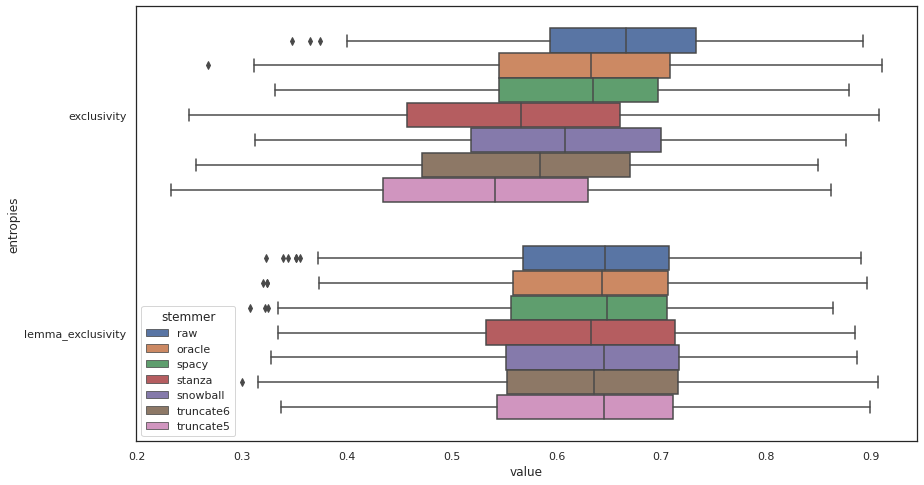

In [15]:
exclusivity_metrics = ['exclusivity', 'lemma_exclusivity']
exclusivity_stats = pd.melt(topics_50_df, "stemmer", var_name="entropies", value_vars=exclusivity_metrics)

fig, axs = plt.subplots(figsize=(14, 8))
sns.boxplot(x="value", y="entropies", hue="stemmer", data=exclusivity_stats, hue_order=hue_order)

In [16]:
# It's a little concerning that these are not the same, they should be. Need to follow up and check post-stemming in pipeline, maybe I'm missing something in building new mallet state or sequence files for post stem models..
oracle_50_topics_df = topics_50_df[topics_50_df["stemmer"] == "oracle"]
print("Oracle exclusivity:", oracle_50_topics_df['exclusivity'].mean())
print("Oracle lemma exclusivity:", oracle_50_topics_df['lemma_exclusivity'].mean())

Oracle exclusivity: 0.6247166
Oracle lemma exclusivity: 0.6316504


# Variation of Information